In [1]:
import torch
from family_training import FamilyShapeSDFWrapper, load_wrapper_from_dir
from models import SingleShapeSDF
import trimesh
import meshplot
import numpy as np
from mesh_to_sdf import sample_sdf_near_surface, scale_to_unit_sphere
from torch.utils.data import DataLoader, TensorDataset, random_split
from test_fnn import visualize_voxels_png


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
device

'cuda'

## Load mesh

In [3]:
mesh = trimesh.load('data/torus.obj')

In [4]:
p = meshplot.plot(mesh.vertices, mesh.faces, c=np.array(mesh.vertices)[:,1])

/home/ivan/anaconda3/envs/mydeepsdf/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(
/home/ivan/anaconda3/envs/mydeepsdf/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(7.5995922…

## Sample points

In [5]:
# it will take time, I warn you

# points, sdf = sample_sdf_near_surface(mesh, number_of_points=300000)

# load points instead

with open('data/torus.npy', 'rb') as f:
    points = np.load(f)
    sdf = np.load(f)

In [6]:
mesh = scale_to_unit_sphere(mesh)
p = meshplot.plot(mesh.vertices, mesh.faces, filename="debug/test_pointsampling.html")
p.add_points(points, c=sdf,
                shading={"point_size": 0.08,
                         "alpha": 0.3,
                         "normalize": [True, True],
                         "colormap": "jet"})
p.add_points(points=np.array([[-0.5,0,0.5],[0.5,0,0.5]]), shading = {"point_size": 1})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

2

### (optional) Save points

In [7]:
# with open("data/torus.npy", 'wb') as f:
#     np.save(f, points)
#     np.save(f, sdf)

## Create model

In [8]:
model = SingleShapeSDF([512, 512, 512]).to(device)

print(model)

SingleShapeSDF(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)


### pytorch dataloaders + balanced sampling

In [9]:
features = torch.from_numpy(points)
labels = torch.from_numpy(sdf)
dataset = TensorDataset(features, labels)

sampling_weights = np.ones_like(sdf)
positive_part = np.sum(sdf>0) / sdf.shape[0]
negative_part = np.sum(sdf<0) / sdf.shape[0]
sampling_weights[sdf>0] = negative_part
sampling_weights[sdf<0] = positive_part

sampler = torch.utils.data.sampler.WeightedRandomSampler(sampling_weights, len(sampling_weights))         


train_loader = DataLoader(dataset,
                          batch_size=16384,
                          sampler = sampler,
                          num_workers=8)

#### Check that the sampling is balanced

In [10]:
iterat = iter(train_loader)
d1, l1 = next(iterat)

In [11]:
np.sum(l1.numpy()>0)

8283

In [12]:
np.sum(l1.numpy()<0)

8101

## Define loss function
$$\mathcal L (f_\theta(\mathbf x), s) = |\text{clamp}(f_\theta(\mathbf x), \delta) - \text{clamp}(s, \delta) |$$ 


$$\text{clamp}(x, \delta) = \min (\delta, \max (-\delta, x))$$

In [13]:
def deepsdfloss(outputs, targets, delta=0.1):
    return torch.mean(torch.abs(
        torch.clamp(outputs, min=-delta, max=delta) - torch.clamp(targets, min=-delta, max=delta)
    ))

### Training

In [14]:
n_epochs = 260
learning_rate=1e-4

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
t_history = []
for epoch in range(n_epochs):
    model.train(True)
    print(f"\nEpoch {epoch}")
    running_loss = 0
    total_loss = 0
    for i, data in enumerate(train_loader, 0):
        x, y = data[0].to(device), data[1].unsqueeze(1).to(device)
        y_pred = model(x)
        loss = deepsdfloss(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_loss += loss.item()
        if i % 5 == 4:
            print(i, running_loss)
            running_loss = 0

    t_history.append(total_loss)
    if epoch%5 == 4:
        visualize_voxels_png(model, filename=f"img/{epoch}.png")



Epoch 0
4 0.12572748214006424
9 0.1012163758277893
14 0.09084418788552284

Epoch 1
4 0.0774219911545515
9 0.0729320328682661
14 0.06861947290599346

Epoch 2
4 0.06212071515619755
9 0.05921512749046087
14 0.05719404388219118

Epoch 3
4 0.05297917686402798
9 0.05135836452245712
14 0.04987554717808962

Epoch 4
4 0.04703130666166544
9 0.045425922609865665
14 0.044482238590717316

Epoch 5
4 0.0427742637693882
9 0.04129177983850241
14 0.04027316998690367

Epoch 6
4 0.038477891124784946
9 0.0374977421015501
14 0.03672877140343189

Epoch 7
4 0.034933455754071474
9 0.03361899312585592
14 0.03309161541983485

Epoch 8
4 0.03176865680143237
9 0.031161578372120857
14 0.030245068948715925

Epoch 9
4 0.029805252328515053
9 0.02938069123774767
14 0.028720364905893803

Epoch 10
4 0.027941225562244654
9 0.026885007042437792
14 0.026900446508079767

Epoch 11
4 0.02580549195408821
9 0.02589676808565855
14 0.025531223975121975

Epoch 12
4 0.025044186506420374
9 0.024396691471338272
14 0.02409466542303562


4 0.012445233296602964
9 0.012536740396171808
14 0.012153226183727384

Epoch 105
4 0.012483865953981876
9 0.011816480895504355
14 0.011973686050623655

Epoch 106
4 0.011964013800024986
9 0.012103033950552344
14 0.011907344218343496

Epoch 107
4 0.01227613678202033
9 0.012131880037486553
14 0.012399816419929266

Epoch 108
4 0.011806715745478868
9 0.012020574416965246
14 0.011809194693341851

Epoch 109
4 0.012350602308288217
9 0.011923444690182805
14 0.011874240124598145

Epoch 110
4 0.012228016275912523
9 0.012228278908878565
14 0.012033171486109495

Epoch 111
4 0.012386714108288288
9 0.012234851950779557
14 0.012093110242858529

Epoch 112
4 0.011907620588317513
9 0.01213782443664968
14 0.012212564935907722

Epoch 113
4 0.011983364587649703
9 0.012160915648564696
14 0.012202514801174402

Epoch 114
4 0.011634608497843146
9 0.01170750823803246
14 0.011777963489294052

Epoch 115
4 0.012079025618731976
9 0.01187361660413444
14 0.0119146928191185

Epoch 116
4 0.01196819613687694
9 0.01186600

4 0.011084204073995352
9 0.011161989299580455
14 0.011232288088649511

Epoch 207
4 0.011075177229940891
9 0.011142965871840715
14 0.010988932801410556

Epoch 208
4 0.010753297712653875
9 0.011036566225811839
14 0.011350124841555953

Epoch 209
4 0.011337968753650784
9 0.010959913255646825
14 0.010997625533491373

Epoch 210
4 0.011151864426210523
9 0.010769149288535118
14 0.01115847728215158

Epoch 211
4 0.010799501556903124
9 0.010867808945477009
14 0.010782466502860188

Epoch 212
4 0.010888635413721204
9 0.010941198095679283
14 0.011011222843080759

Epoch 213
4 0.010956990998238325
9 0.010826172074303031
14 0.010650984942913055

Epoch 214
4 0.010900235967710614
9 0.010779138188809156
14 0.011078373296186328

Epoch 215
4 0.010723170824348927
9 0.010622353525832295
14 0.010875033680349588

Epoch 216
4 0.010893792379647493
9 0.011112408246845007
14 0.011094475165009499

Epoch 217
4 0.011183731956407428
9 0.010789838852360845
14 0.010863133240491152

Epoch 218
4 0.011231448035687208
9 0.01

In [16]:
torch.save(model.state_dict(), "torusSDF-512.pt")

### Loading

In [17]:
loadmodel = SingleShapeSDF([512, 512, 512]).to(device)
loadmodel.load_state_dict(torch.load("torusSDF-512.pt"))

<All keys matched successfully>

In [18]:
from test_fnn import visualize_marchingcubes, visualize_voxels

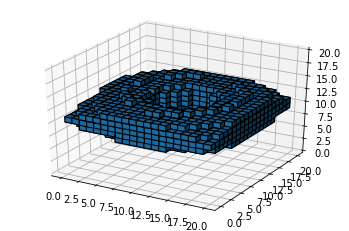

In [20]:
visualize_voxels(loadmodel)

### Normals

In [21]:
point = np.float32([[-0.3,0,0]])


myxyz = torch.autograd.Variable(torch.from_numpy(point)).to(device)
myxyz.requires_grad = True
print(myxyz)
loadmodel.zero_grad()
l = loadmodel.forward(myxyz)

l.backward()

print(myxyz.grad)

tensor([[-0.3000,  0.0000,  0.0000]], device='cuda:0', requires_grad=True)
tensor([[ 1.7904,  0.0043, -0.4787]], device='cuda:0')


In [22]:
point_end = point + myxyz.grad.cpu().numpy()

In [23]:
mesh = scale_to_unit_sphere(mesh)
p = meshplot.plot(mesh.vertices, mesh.faces, 
                  c=np.array(mesh.vertices)[:,1],
                  filename="debug/test_pointsampling.html")
p.add_lines(point, point_end, shading={"line_color": "red"})
p.add_points(point, shading = {"point_size": 1})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

2